In [1]:
from pyspark.sql import SparkSession

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 1")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '64g')
    .config('spark.executor.memory', '64g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/08/19 05:19:03 WARN Utils: Your hostname, flgg resolves to a loopback address: 127.0.1.1; using 172.28.210.36 instead (on interface eth0)
23/08/19 05:19:03 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/19 05:19:04 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# read in tlc data
df_1 = spark.read.parquet('../data/raw/2023/yellow_tripdata_2023-01.parquet')
df_2 = spark.read.parquet('../data/raw/2023/yellow_tripdata_2023-02.parquet')
df_3 = spark.read.parquet('../data/raw/2023/yellow_tripdata_2023-03.parquet')
df_7 = spark.read.parquet('../data/raw/2022/yellow_tripdata_2022-07.parquet')
df_8 = spark.read.parquet('../data/raw/2022/yellow_tripdata_2022-08.parquet')
df_9 = spark.read.parquet('../data/raw/2022/yellow_tripdata_2022-09.parquet')
df_10 = spark.read.parquet('../data/raw/2022/yellow_tripdata_2022-10.parquet')
df_11 = spark.read.parquet('../data/raw/2022/yellow_tripdata_2022-11.parquet')
df_12 = spark.read.parquet('../data/raw/2022/yellow_tripdata_2022-12.parquet')

In [3]:
# generate the combined tlc data
df_combined = df_9.union(df_10).union(df_11).union(df_12).union(df_1).union(df_2).union(df_3)
df_combined.count()

22895931

In [4]:
from pyspark.sql.functions import unix_timestamp
from pyspark.sql.functions import col, hour
from pyspark.sql.functions import when
from pyspark.sql import functions as F
from pyspark.sql.functions import date_format

In [5]:
# first preprocessing
df_combined = df_combined.withColumn("time_set", when((hour(col("tpep_pickup_datetime")) >= 5) & (hour(col("tpep_pickup_datetime")) < 12), "Morning")\
.when((hour(col("tpep_pickup_datetime")) >= 12) & (hour(col("tpep_pickup_datetime")) < 18), "Afternoon")\
.when((hour(col("tpep_pickup_datetime")) >= 18) & (hour(col("tpep_pickup_datetime")) < 23), "Evening")\
.otherwise("Late Night"))\
.withColumn('time_duration_minutes', (unix_timestamp('tpep_dropoff_datetime') - unix_timestamp('tpep_pickup_datetime')) / 60)\
.withColumn('average_speed', F.col('trip_distance') / (F.col('time_duration_minutes') / 60))

df_combined = df_combined.where(F.col('time_duration_minutes') >= 1).where(F.col('tip_amount') > 0)\
.where(F.col('trip_distance') > 0).where(F.col('payment_type') == 1)\
.where(F.col('fare_amount') >= 3)


In [6]:
df_combined.count()

16797787

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbs

In [8]:
# generate the sample data
sampled_df = df_combined.sample(False, 0.05)
sampled_df.count()


839836

In [9]:
sampled_df = sampled_df.toPandas()

/home/flgg/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)
/home/flgg/.local/lib/python3.10/site-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [10]:
cols = ['trip_distance', 'fare_amount', 'average_speed', 'time_duration_minutes', 'tip_amount']

In [11]:
label = ['Trip Distance', 'Fare Amount', 'Average Speed', 'Time Duration', 'Tip Amount']
path = '../plots/tlc_distribution_analyze 1.png'

def box_plot(sdf):
    fig, axs = plt.subplots(1, 5, figsize = (15,5))
    axs[0].boxplot(sdf[cols[0]])
    axs[0].set_xlabel(label[0], size = 16)
    axs[1].boxplot(sdf[cols[1]])
    axs[1].set_xlabel(label[1], size = 16)
    axs[2].boxplot(sdf[cols[2]])
    axs[2].set_xlabel(label[2], size = 16)
    axs[3].boxplot(sdf[cols[3]])
    axs[3].set_xlabel(label[3], size = 16)
    axs[4].boxplot(sdf[cols[4]])
    axs[4].set_xlabel(label[4], size = 16)
    plt.savefig(path)
    plt.show()


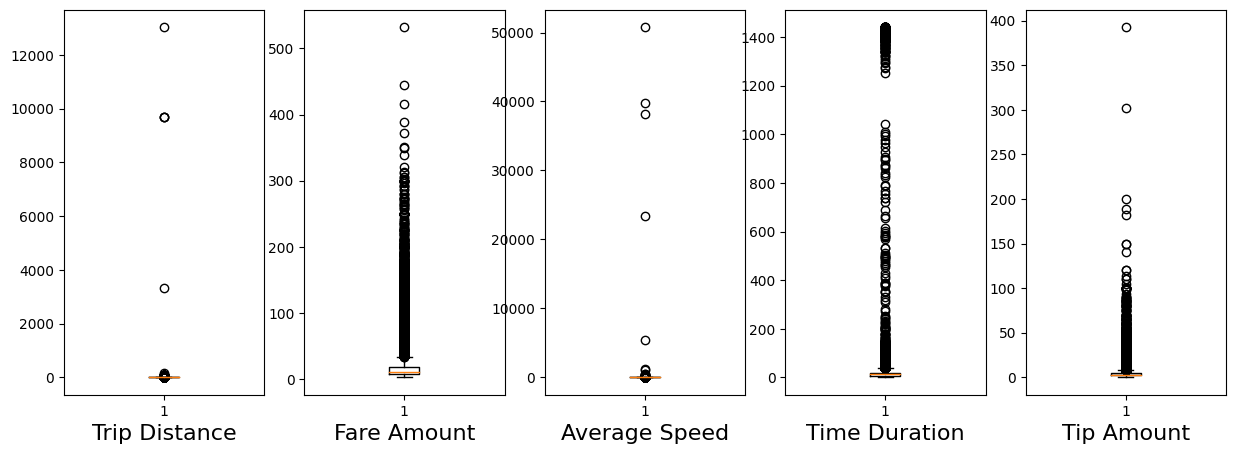

In [12]:
box_plot(sampled_df)

In [13]:
def compute_bounds(column):
    Q1 = sampled_df[column].quantile(0.25)
    Q3 = sampled_df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

cleaned_df = sampled_df

for column in cols:
    lower, upper = compute_bounds(column)
    # 使用Pandas DataFrame的过滤功能
    cleaned_df = cleaned_df[(cleaned_df[column] >= lower) & (cleaned_df[column] <= upper)]


In [14]:
path = '../plots/tlc_distribution_analyze 2.png'

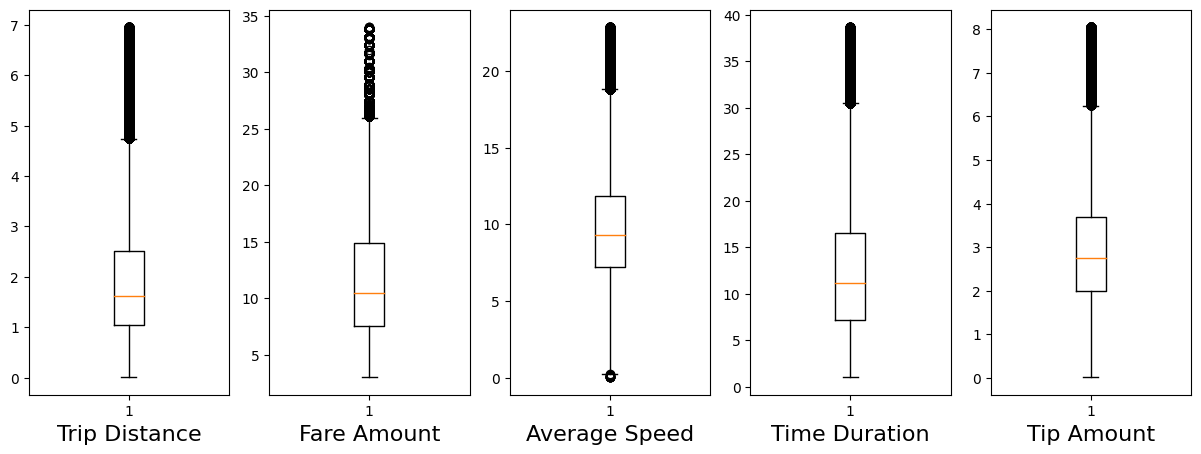

In [15]:
box_plot(cleaned_df)

In [16]:
cleaned_df.to_parquet('../data/curated/sample.parquet')

In [17]:

spark = SparkSession.builder.appName("DataFrameTransformations").getOrCreate()

cols = ['trip_distance', 'fare_amount', 'average_speed', 'time_duration_minutes', 'tip_amount']

def transform_df(df):
    return (df.withColumn("time_set",
                when((hour(col("tpep_pickup_datetime")) >= 5) & (hour(col("tpep_pickup_datetime")) < 12), "Morning")
                .when((hour(col("tpep_pickup_datetime")) >= 12) & (hour(col("tpep_pickup_datetime")) < 18), "Afternoon")
                .when((hour(col("tpep_pickup_datetime")) >= 18) & (hour(col("tpep_pickup_datetime")) < 23), "Evening")
                .otherwise("Late Night"))
            .withColumn('time_duration_minutes', (unix_timestamp('tpep_dropoff_datetime') - unix_timestamp('tpep_pickup_datetime')) / 60)
            .withColumn('average_speed', F.col('trip_distance') / (F.col('time_duration_minutes') / 60))
            .where(F.col('time_duration_minutes') >= 1)
            .where(F.col('tip_amount') > 0)
            .where(F.col('trip_distance') > 0)
            .where(F.col('payment_type') == 1)
            .where(F.col('fare_amount') >= 3))

def compute_bounds(df, column):
    Q1, Q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return lower_bound, upper_bound

def remove_outliers(df, cols):
    for column in cols:
        lower, upper = compute_bounds(df, column)
        df = df.filter((col(column) >= lower) & (col(column) <= upper))
    return df

# 数据集列表
dfs = [df_9, df_10, df_11, df_12, df_1, df_2, df_3]

# 对每个数据集应用上述函数，并执行union操作
resulting_df = None
for df in dfs:
    transformed = transform_df(df)
    cleaned = remove_outliers(transformed, cols)
    if resulting_df is None:
        resulting_df = cleaned
    else:
        resulting_df = resulting_df.union(cleaned)


23/08/19 05:19:41 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [18]:
resulting_df.count()

13058002

In [19]:
resulting_df.write.parquet('../data/curated/first_clean')